# 深度卷积生成对抗网络 (DCGAN)

### 目标
在这个笔记本中，您将使用MNIST数据集创建另一个GAN。您将实现一个深度卷积生成对抗网络（DCGAN），这是一个在2015年开发的非常成功和有影响力的GAN模型。

*注意：[这里](https://arxiv.org/pdf/1511.06434v1.pdf)是相关论文，如果您感兴趣的话！现在看起来可能有些复杂，但很快您将能够理解其中的许多部分 :)*

### 学习目标
1.   获得制作广泛使用的GAN的实践经验：深度卷积生成对抗网络（DCGAN）。
2.   训练一个强大的生成模型。

![生成器架构](dcgan-gen.png)

图：来自[Radford等人（2016）](https://arxiv.org/pdf/1511.06434v1.pdf)的DCGAN生成器的架构图。

## 开始

#### DCGAN
以下是DCGAN的主要特点（不用担心记住这些，您将在实现过程中得到指导！）：

*   使用无池化层的卷积
*   在生成器和判别器中使用批归一化
*   不使用全连接隐藏层
*   在生成器中对所有层使用ReLU激活，输出层使用Tanh激活。
*   在判别器中对所有层使用LeakyReLU激活，输出层不使用激活

您将开始导入一些有用的包和数据，以帮助您创建自己的GAN。您还将获得一个可视化函数，以帮助查看您的GAN将生成的图像。

In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for testing purposes, please do not change!


def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

## 生成器
您将要制作的第一个组件是生成器。您可能会注意到，您将传递给生成器的不是图像维度，而是图像通道的数量。这是因为在DCGAN中，您使用的卷积与图像上的像素数量无关。然而，通道的数量对于确定滤波器的大小是很重要的。

您将使用4层（3个隐藏层 + 1个输出层）构建一个生成器。与之前一样，您需要编写一个函数来创建生成器神经网络的单个模块。
<!-- 从论文中，我们知道要“在生成器和判别器中使用批标准化”和“在生成器中所有层使用ReLU激活，除了输出层使用Tanh。” -->
由于在DCGAN中激活函数对于输出层是不同的，您需要检查正在创建哪个层。您在代码单元后面提供了一些测试，以便您可以查看自己是否在正确的轨道上！

在生成器类的最后，您将获得一个前向传播函数，该函数接受一个噪声向量，并使用您的神经网络生成输出维度的图像。您还将获得一个创建噪声向量的函数。这些函数与上一个作业中的函数相同。

<details>
<summary>
<font size="3" color="green">
<b>关于 <code><font size="4">make_gen_block</font></code> 的可选提示</b>
</font>
</summary>

1. 您会发现 [nn.ConvTranspose2d](https://pytorch.org/docs/master/generated/torch.nn.ConvTranspose2d.html) 和 [nn.BatchNorm2d](https://pytorch.org/docs/master/generated/torch.nn.BatchNorm2d.html) 非常有用！
</details>

In [2]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: Generator
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        返回一个与DCGAN生成器块对应的操作序列的函数，包含一个反卷积、一个批量归一化（最后一层除外）和一个激活函数。
        参数：
            input_channels：输入特征表示的通道数
            output_channels：输出特征表示应具有的通道数
            kernel_size：每个卷积滤波器的大小，相当于（kernel_size，kernel_size）
            stride：卷积的步幅
            final_layer：一个布尔值，如果是最后一层则为真，否则为假
                      （影响激活和批量归一化）
        '''
        # 步骤：
        #  1）使用给定参数进行反卷积。
        #  2）进行批量归一化，最后一层除外。
        #  3）在每个批量归一化后应用ReLU激活函数。
        #  4）如果是最后一层，在反卷积后使用Tanh激活函数。

        # 构建神经块
        if not final_layer:
            return nn.Sequential(
                #### START CODE HERE ####
                nn.ConvTranspose2d(input_channels, out_channels=output_channels, kernel_size=kernel_size, stride=stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU()
                #### END CODE HERE ####
            )
        else: # Final Layer
            return nn.Sequential(
                #### START CODE HERE ####
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size=kernel_size, stride=stride),
                nn.Tanh()
                #### END CODE HERE ####
            )

    def unsqueeze_noise(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns a copy of that noise with width and height = 1 and channels = z_dim.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        x = self.unsqueeze_noise(noise)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)

In [3]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
'''
Test your make_gen_block() function
'''
gen = Generator()
num_test = 100

# Test the hidden block
test_hidden_noise = get_noise(num_test, gen.z_dim)
test_hidden_block = gen.make_gen_block(10, 20, kernel_size=4, stride=1)
test_uns_noise = gen.unsqueeze_noise(test_hidden_noise)
hidden_output = test_hidden_block(test_uns_noise)

# Check that it works with other strides
test_hidden_block_stride = gen.make_gen_block(20, 20, kernel_size=4, stride=2)

test_final_noise = get_noise(num_test, gen.z_dim) * 20
test_final_block = gen.make_gen_block(10, 20, final_layer=True)
test_final_uns_noise = gen.unsqueeze_noise(test_final_noise)
final_output = test_final_block(test_final_uns_noise)

# Test the whole thing:
test_gen_noise = get_noise(num_test, gen.z_dim)
test_uns_gen_noise = gen.unsqueeze_noise(test_gen_noise)
gen_output = gen(test_uns_gen_noise)

Here's the test for your generator block:

In [4]:
# UNIT TESTS
assert tuple(hidden_output.shape) == (num_test, 20, 4, 4)
assert hidden_output.max() > 1
assert hidden_output.min() == 0
assert hidden_output.std() > 0.2
assert hidden_output.std() < 1
assert hidden_output.std() > 0.5

assert tuple(test_hidden_block_stride(hidden_output).shape) == (num_test, 20, 10, 10)

assert final_output.max().item() == 1
assert final_output.min().item() == -1

assert tuple(gen_output.shape) == (num_test, 1, 28, 28)
assert gen_output.std() > 0.5
assert gen_output.std() < 0.8
print("Success!")

Success!


## 判别器
您需要创建的第二个组件是判别器。

您将在判别器的神经网络中使用3层。与生成器一样，您需要为判别器创建一个单独的神经网络模块的函数。
<!-- 从论文中，我们知道我们需要在判别器的所有层中“使用LeakyReLU激活”。而对于LeakyReLUs，“泄漏的斜率设置为0.2”在DCGAN中。 -->
最后还有测试供您使用。
<details>
<summary>
<font size="3" color="green">
<b>关于<code><font size="4">make_disc_block</font></code>的可选提示</b>
</font>
</summary>

1. 你会发现 [nn.Conv2d](https://pytorch.org/docs/master/generated/torch.nn.Conv2d.html)、[nn.BatchNorm2d](https://pytorch.org/docs/master/generated/torch.nn.BatchNorm2d.html) 和 [nn.LeakyReLU](https://pytorch.org/docs/master/generated/torch.nn.LeakyReLU.html) 非常有用！
</details>

In [5]:
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: Discriminator
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
    hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        返回与 DCGAN 的判别器块对应的一系列操作的函数，
        包括卷积、批归一化（最后一层除外）和激活。
        参数：
            input_channels: 输入特征表示的通道数
            output_channels: 输出特征表示的通道数
            kernel_size: 每个卷积滤波器的大小，相当于 (kernel_size, kernel_size)
            stride: 卷积的步幅
            final_layer: 一个布尔值，如果是最后一层则为真，否则为假
                      （影响激活和批归一化）
        '''
        #     步骤：
        #       1）使用给定参数添加卷积层。
        #       2）进行批归一化，最后一层除外。
        #       3）在每个批归一化后跟随一个斜率为 0.2 的 LeakyReLU 激活。
        #       注意：最后一层不要使用激活

        # 构建神经块
        if not final_layer:
            return nn.Sequential(
                #### START CODE HERE #### #
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2)
                #### END CODE HERE ####
            )
        else: # Final Layer
            return nn.Sequential(
                #### START CODE HERE #### #
                nn.Conv2d(input_channels, output_channels, kernel_size, stride)
                #### END CODE HERE ####
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

In [6]:
# UNQ_C4 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
'''
Test your make_disc_block() function
'''
num_test = 100

gen = Generator()
disc = Discriminator()
test_images = gen(get_noise(num_test, gen.z_dim))

# Test the hidden block
test_hidden_block = disc.make_disc_block(1, 5, kernel_size=6, stride=3)
hidden_output = test_hidden_block(test_images)

# Test the final block
test_final_block = disc.make_disc_block(1, 10, kernel_size=2, stride=5, final_layer=True)
final_output = test_final_block(test_images)

# Test the whole thing:
disc_output = disc(test_images)

这是对你辨别器模块的测试：

In [7]:
# Test the hidden block
assert tuple(hidden_output.shape) == (num_test, 5, 8, 8)
# Because of the LeakyReLU slope
assert -hidden_output.min() / hidden_output.max() > 0.15
assert -hidden_output.min() / hidden_output.max() < 0.25
assert hidden_output.std() > 0.5
assert hidden_output.std() < 1

# Test the final block

assert tuple(final_output.shape) == (num_test, 10, 6, 6)
assert final_output.max() > 1.0
assert final_output.min() < -1.0
assert final_output.std() > 0.3
assert final_output.std() < 0.6

# Test the whole thing:

assert tuple(disc_output.shape) == (num_test, 1)
assert disc_output.std() > 0.25
assert disc_output.std() < 0.5
print("Success!")

Success!


## Training
Now you can put it all together!
Remember that these are your parameters:
  *   criterion: the loss function
  *   n_epochs: the number of times you iterate through the entire dataset when training
  *   z_dim: the dimension of the noise vector
  *   display_step: how often to display/visualize the images
  *   batch_size: the number of images per forward/backward pass
  *   lr: the learning rate
  *   beta_1, beta_2: the momentum term
  *   device: the device type

<!-- In addition, be warned that **this runs very slowly on the default CPU**. One way to run this more quickly is to download the .ipynb and upload it to Google Drive, then open it with Google Colab, click on `Runtime -> Change runtime type` and set hardware accelerator to GPU and replace
`device = "cpu"`
with
`device = "cuda"`. The code should then run without any more changes, over 1,000 times faster.  -->


In [8]:
criterion = nn.BCEWithLogitsLoss()
z_dim = 64
display_step = 500
batch_size = 128
# A learning rate of 0.0002 works well on DCGAN
lr = 0.0002

# These parameters control the optimizer's momentum, which you can read more about here:
# https://distill.pub/2017/momentum/ but you don’t need to worry about it for this course!
beta_1 = 0.5 
beta_2 = 0.999
# 尝试使用GPU, 如果失败则使用CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# You can tranform the image values to be between -1 and 1 (the range of the tanh activation)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=False, transform=transform),
    batch_size=batch_size,
    shuffle=True)

In [9]:
device

'cpu'

Then, you can initialize your generator, discriminator, and optimizers.

In [10]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

# You initialize the weights to the normal distribution
# with mean 0 and standard deviation 0.02
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

Finally, you can train your GAN!
For each epoch, you will process the entire dataset in batches. For every batch, you will update the discriminator and generator. Then, you can see DCGAN's results!

Here's roughly the progression you should be expecting. On GPU this takes about 30 seconds per thousand steps. On CPU, this can take about 8 hours per thousand steps. You might notice that in the image of Step 5000, the generator is disproprotionately producing things that look like ones. If the discriminator didn't learn to detect this imbalance quickly enough, then the generator could just produce more ones. As a result, it may have ended up tricking the discriminator so well that there would be no more improvement, known as mode collapse: 
![MNIST Digits Progression](MNIST_DCGAN_Progression.png)


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1, step 500: Generator loss: 0.9229019594788556, discriminator loss: 0.5185920003056532


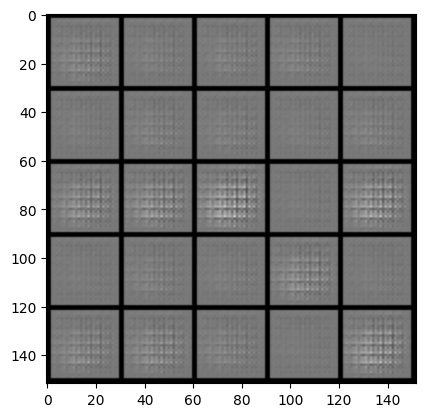

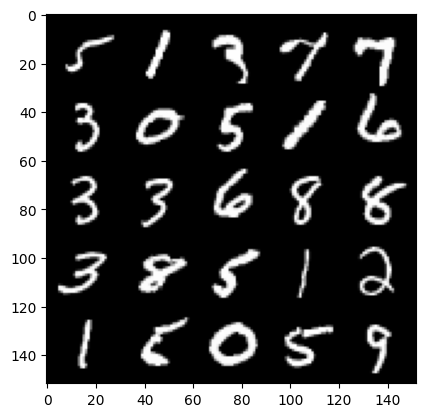

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2, step 1000: Generator loss: 2.230231481075287, discriminator loss: 0.1508877128958701


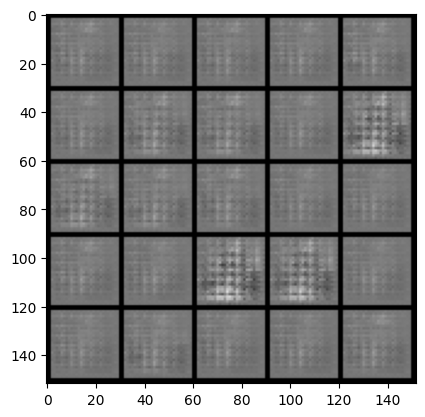

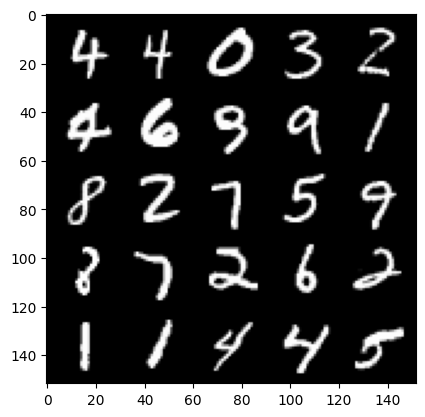

In [14]:
n_epochs = 50
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        ## Update discriminator ##
        disc_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        disc_fake_pred = disc(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step
        # Update gradients
        disc_loss.backward(retain_graph=True)
        # Update optimizer
        disc_opt.step()

        ## Update generator ##
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ## Visualization code ##
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Epoch {epoch}, step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1
